In [ ]:
# manually tries different post-processing strategies on the labelled data to find good parameters
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import load_data, load_test_predictions,  handle_small_segments, get_bbox_margin, get_metrics, compute_auc, get_shells, smooth_segments, load_predictions, handle_small_segments_simple, find_central_id, merge_in_rbc, delete_boundary_segments
from post_process import post_process
from skimage.measure import regionprops
from skimage.morphology import ball, dilation, erosion

In [2]:
# on labelled data

In [3]:
data_path = "/export/home/sdamrich/data_ial/sfb1129/protein_kinetics/RBC_labelled"

datasets = ["valid1", "valid2", "valid3"]

In [4]:
#load data
data_dict = {}
for dataset in datasets:
    imgs, gt, file_names = load_data(data_path, dataset)
    data_dict[dataset] = {"imgs": imgs,
                          "gt": gt,
                          "file_names": file_names}

In [4]:
# check out size of segments
all_counts = []
for dataset in datasets:
    for gt in data_dict[dataset]["gt"]:
        _, counts = np.unique(gt, return_counts=True)
        all_counts.append(counts[1:])
all_counts = np.concatenate(all_counts)


In [153]:
seed = 0
n_folds = 10
eval_str_3D = "data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_epoch_499_aniso_3.2"
for dataset in datasets:
    test_pred_3D, test_idx_3D = load_test_predictions(data_path,
                                     dataset,
                                     data_dict[dataset]["file_names"],
                                     eval_str_3D,
                                     seed=seed,
                                     n_folds=n_folds)
    reverse_idx = np.argsort(test_idx_3D)
    test_pred_3D = test_pred_3D[reverse_idx]
    data_dict[dataset]["pred_3D"] = test_pred_3D

In [6]:
counts_3D = []
for dataset in datasets:
    for seg in data_dict[dataset]["pred_3D"]:
        _, counts = np.unique(seg, return_counts=True)
        counts_3D.append(counts[1:])
counts_3D = np.concatenate(counts_3D)

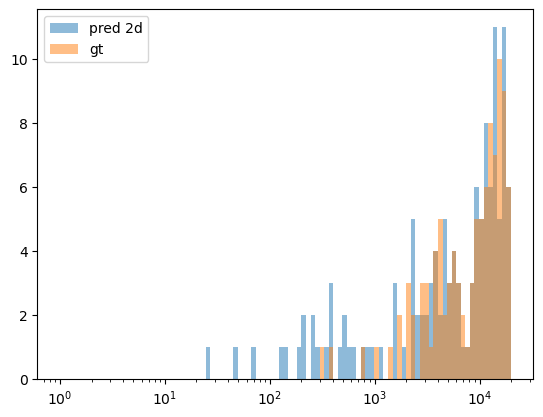

In [7]:
bins = np.exp(np.arange(100)/10)
plt.hist(counts_3D, bins=bins, alpha=0.5, label="pred 2d")
plt.hist(all_counts, bins=bins, alpha=0.5, label="gt")
plt.legend()
plt.xscale("log")

In [8]:
# there are small segments
(counts_3D <2000).sum()

28

In [9]:
# test handling of small segments (deprecated)

In [10]:
%%time
for seg in data_dict["valid2"]["pred_3D"]:
    handle_small_segments(seg, 2000, 3)

CPU times: user 650 ms, sys: 576 µs, total: 651 ms
Wall time: 649 ms


In [11]:
sample_id = 12
sample_seg = data_dict["valid2"]["pred_3D"][sample_id]

In [12]:
_, c = np.unique(sample_seg, return_counts=True)
print(c)

[583095  57290   4283   5316    633    370    529    210    387    203
     46    138]


In [13]:
merged_seg = handle_small_segments(sample_seg, 2000, 3)

In [14]:
_, c = np.unique(merged_seg, return_counts=True)
print(c)

[583095  59806   4283   5316]


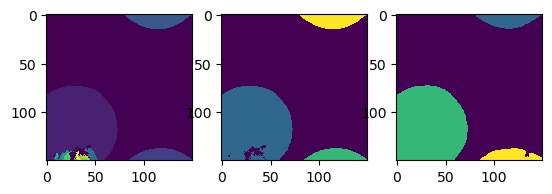

In [15]:
z = 8

fig, ax = plt.subplots(1, 3)
ax[0].imshow(sample_seg[z], interpolation="none")
ax[1].imshow(merged_seg[z], interpolation="none")
ax[2].imshow(data_dict["valid2"]["gt"][sample_id][z], interpolation="none")

In [16]:
# quantitative eval

In [124]:
%%time
min_sizes = np.arange(0, 20)*100
ngbh_sizes = [0, 1, 2]
merged_aucs = np.zeros(shape=(len(min_sizes), len(ngbh_sizes)))
merged_shell_aucs = np.zeros(shape=(len(min_sizes), len(ngbh_sizes)))

for i, min_size in enumerate(min_sizes):
    for j, ngbh_size in enumerate(ngbh_sizes):
        for dataset in data_dict.keys():
            if "gt_shells" not in data_dict[dataset].keys():
                gt_shells = np.zeros_like(data_dict[dataset]["gt"])
                for i, seg in enumerate(data_dict[dataset]["gt"]):
                    gt_shells[i] = get_shells(seg, 1, 1 )
                data_dict[dataset]["gt_shells"] = gt_shells
            merged_segs = []
            merged_segs_shells = []
            for seg in data_dict[dataset]["pred_3D"]:
                merged_seg = handle_small_segments(seg, min_size, ngbh_size)
                merged_segs.append(merged_seg)
                merged_segs_shells.append(get_shells(merged_seg))

            data_dict[dataset]["merged_3D"] = np.stack(merged_segs)
            data_dict[dataset]["merged_3D_shells"] = np.stack(merged_segs_shells)

        merged_aucs[i,j] = compute_auc(data_dict, stage="merged_3D")
        merged_shell_aucs[i,j] = compute_auc(data_dict, stage="merged_3D_shells", gt_stage="gt_shells")


CPU times: user 4min 18s, sys: 2.56 s, total: 4min 21s
Wall time: 4min 21s


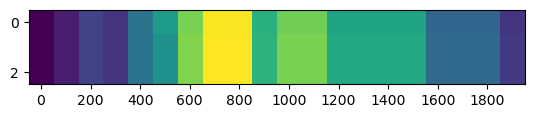

In [125]:
plt.imshow(merged_aucs.T)
_ = plt.xticks(np.arange(len(min_sizes))[::2], min_sizes[::2])

In [126]:
max_auc = merged_aucs.max()

idx = np.argwhere(merged_aucs == max_auc)[0]


print(f"AUC before merging {compute_auc(data_dict)}")
print(f"Best combination is min_size={min_sizes[idx[0]]} and nghb_size={ngbh_sizes[idx[1]]}")
print(f"Best AUC after merging {merged_aucs.max()}")


AUC before merging 0.8068270980913027
Best combination is min_size=700 and nghb_size=1
Best AUC after merging 0.8225773358585858


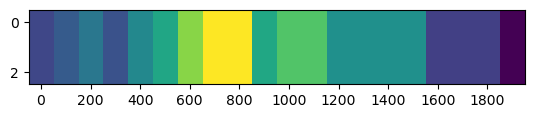

In [127]:
plt.imshow(merged_shell_aucs.T)
_ = plt.xticks(np.arange(len(min_sizes))[::2], min_sizes[::2])

In [128]:
max_auc = merged_shell_aucs.max()

idx = np.argwhere(merged_shell_aucs == max_auc)[0]

for dataset in data_dict:
    pred_3D_shells = np.zeros_like(data_dict[dataset]["gt"])
    for i, seg in enumerate(data_dict[dataset]["pred_3D"]):
        pred_3D_shells[i] = get_shells(seg, 1, 1 )
    data_dict[dataset]["pred_3D_shells"] = pred_3D_shells

print(f"AUC before merging {compute_auc(data_dict, stage='pred_3D_shells', gt_stage='gt_shells' )}")
print(f"Best combination is min_size={min_sizes[idx[0]]} and nghb_size={ngbh_sizes[idx[1]]}")
print(f"Best AUC after merging {merged_shell_aucs.max()}")

AUC before merging 0.6261137103111535
Best combination is min_size=700 and nghb_size=0
Best AUC after merging 0.6360090863997114


In [17]:
# --> filtering small segments helps, but merging small to larger cells does not help much and not at all in terms of shells. But it also does not hurt.

In [18]:
best_min_size = 700
best_nghb_size = 1
for dataset in data_dict.keys():
    merged_segs = []
    for seg in data_dict[dataset]["pred_3D"]:
        merged_segs.append(handle_small_segments(seg, best_min_size, best_nghb_size))
    data_dict[dataset]["merged_3D"] = np.stack(merged_segs)


In [19]:
# get rid or jaggered patterns in z-direction

In [21]:
# qualitative eval

In [22]:
closed_sample_seg = smooth_segments(merged_seg, 2, False)

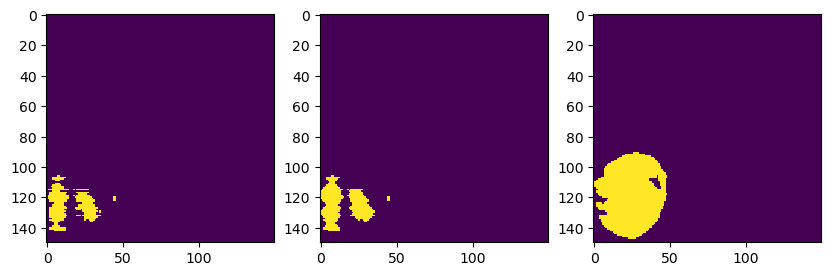

In [33]:
z = 20

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(merged_seg[z], interpolation="none")
ax[1].imshow(closed_sample_seg[z], interpolation="none")
ax[2].imshow(data_dict["valid2"]["gt"][sample_id][z], interpolation="none")

In [58]:
# quantitative analysis

In [35]:
dim_setting = [True, False]
radii = [0, 1, 2, 3, 4, 5]
smoothed_aucs = np.zeros(shape=(len(dim_setting), len(radii)))
smoothed_shell_aucs = np.zeros(shape=(len(dim_setting), len(radii)))

for i, do_3D in enumerate(dim_setting):
    for j, radius in enumerate(radii):
        for dataset in data_dict.keys():
            if "gt_shells" not in data_dict[dataset].keys():
                gt_shells = np.zeros_like(data_dict[dataset]["gt"])
                for i, seg in enumerate(data_dict[dataset]["gt"]):
                    gt_shells[i] = get_shells(seg, 1, 1 )
                data_dict[dataset]["gt_shells"] = gt_shells

            new_segs = []
            new_shells = []
            for seg in data_dict[dataset]["merged_3D"]:
                new_segs.append(smooth_segments(seg, radius, do_3D))
                new_shells.append(get_shells(new_segs[-1], 1, 1))
            data_dict[dataset]["smoothed_3D"] = np.stack(new_segs)
            data_dict[dataset]["smoothed_3D_shells"] = np.stack(new_shells)
        smoothed_aucs[i,j] = compute_auc(data_dict, stage="smoothed_3D")
        smoothed_shell_aucs[i,j] = compute_auc(data_dict, stage="smoothed_3D_shells", gt_stage="gt_shells")

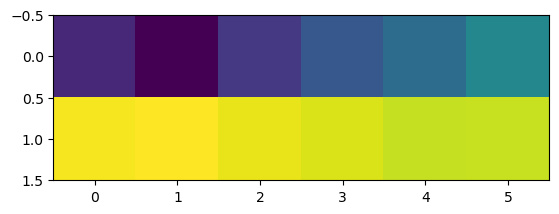

In [36]:
plt.imshow(smoothed_aucs)
#_ = plt.xticks(np.arange(len(dim_setting)), radii)

In [37]:
print(smoothed_aucs)

[[0.76053898 0.75219781 0.76417416 0.77177641 0.77750107 0.7853068 ]
 [0.82257734 0.82357165 0.82108248 0.8194591  0.81735886 0.81761251]]


In [38]:
max_auc = smoothed_aucs.max()

idx = np.argwhere(smoothed_aucs == max_auc)[0]


print(f"AUC before merging {compute_auc(data_dict, stage='merged_3D')}")
print(f"Best combination is do_3D={dim_setting[idx[0]]} and radius={radii[idx[1]]}")
print(f"Best AUC after merging {max_auc}")

AUC before merging 0.8225773358585858
Best combination is do_3D=False and radius=1
Best AUC after merging 0.8235716540404041


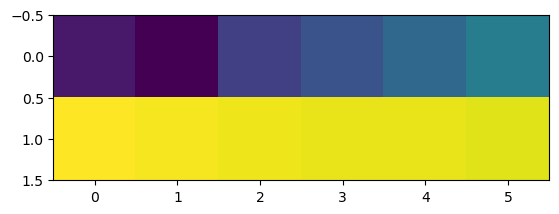

In [39]:
plt.imshow(smoothed_shell_aucs)
#_ = plt.xticks(np.arange(len(dim_setting)), radii)

In [40]:
print(smoothed_shell_aucs)

[[0.48730441 0.47606872 0.50632835 0.51697336 0.53016555 0.54300713]
 [0.63600909 0.63389644 0.63199856 0.63046762 0.63046762 0.62837302]]


In [43]:
max_auc = smoothed_shell_aucs.max()

idx = np.argwhere(smoothed_shell_aucs == max_auc)[0]

for dataset in data_dict:
    pred_3D_shells = np.zeros_like(data_dict[dataset]["gt"])
    for i, seg in enumerate(data_dict[dataset]["merged_3D"]):
        pred_3D_shells[i] = get_shells(seg, 1, 1 )
    data_dict[dataset]["merged_3D_shells"] = pred_3D_shells

print(f"AUC before merging {compute_auc(data_dict, stage='merged_3D_shells', gt_stage='gt_shells' )}")
print(f"Best combination is do_3D={dim_setting[idx[0]]} and radius={radii[idx[1]]}")
print(f"Best AUC after merging {smoothed_shell_aucs.max()}")

AUC before merging 0.6360090863997114
Best combination is do_3D=False and radius=0
Best AUC after merging 0.6360090863997114


# parasites

In [28]:
# load rbc and parasite predictions

data_path = "/export/home/sdamrich/data_ial/sfb1129/protein_kinetics/data_20220615"

datasets = ["mask-ts"]

seed = 0
n_folds = 10

eval_str_para = "data_mask-ts_by_stack_mode_3D_iso_min_train_masks_0_seed_0_epoch_499_aniso_3.2"
eval_str_rbc = "data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_fold_0_of_1_epoch_499_aniso_3.2"


data_dict = {}

for dataset in datasets:
    data_dict[dataset] = {}

    imgs, para_gt, file_names = load_data(data_path, dataset)

    data_dict[dataset]["imgs"] = imgs
    data_dict[dataset]["para_gt"] = para_gt
    data_dict[dataset]["file_names"] = file_names

    para_pred, test_idx = load_test_predictions(data_path,
                                     dataset,
                                     file_names,
                                     eval_str_para,
                                     seed=seed,
                                     n_folds=n_folds)
    reverse_idx = np.argsort(test_idx)
    para_pred = para_pred[reverse_idx]
    data_dict[dataset]["para_pred"] = para_pred

    rbc_pred = load_predictions(data_path, dataset, file_names, eval_str_rbc)
    data_dict[dataset]["rbc_pred"] = rbc_pred

In [29]:
data_dict["mask-ts"]["para_pred"].shape


(23, 29, 150, 150)

In [30]:
# postprocess rbcs

for dataset in data_dict:
    data_dict[dataset]["rbc_pp"] = post_process(data_dict[dataset]["rbc_pred"], stage="rbc_old", radius=1, do_3D=False, nbhd_size=1)


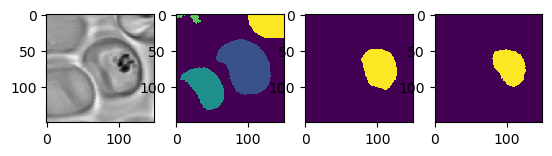

In [32]:
img_id = 4
z = 15
dataset = "mask-ts"

fix, ax = plt.subplots(1, 4)
ax[0].imshow(data_dict[dataset]["imgs"][img_id][z], interpolation="none", cmap="gray")
ax[1].imshow(data_dict[dataset]["rbc_pp"][img_id][z], interpolation="none")
ax[2].imshow(data_dict[dataset]["para_gt"][img_id][z], interpolation="none")
ax[3].imshow(data_dict[dataset]["para_pred"][img_id][z], interpolation="none")

In [33]:
# merge everything inside main rbc

In [44]:
def post_process_para(para_seg, rbc_pp_seg, radius=0, do_3D=True):
    para_seg_merged = merge_in_rbc(para_seg, rbc_pp_seg)
    para_seg_smooth = smooth_segments(para_seg_merged, radius, do_3D)
    return para_seg_smooth


In [40]:
for dataset in data_dict:
    data_dict[dataset]["para_merge"] = merge_in_rbc(data_dict[dataset]["para_pred"],
                                                      data_dict[dataset]["rbc_pp"])
    data_dict[dataset]["para_gt_merge"] = merge_in_rbc(data_dict[dataset]["para_gt"],
                                                         data_dict[dataset]["rbc_pp"])

In [53]:
# only run this for mask_ts  for getting the results of that dataset direct, as requested by Sophia
smoothed = []
for frame in data_dict["mask_ts"]["para_merge"]:
    smoothed.append(smooth_segments(frame, radius=0, do_3d=True))
data_dict[dataset]["para_pp"] = np.stack(smoothed)
print(compute_auc(data_dict, datasets=["mask-ts"], stage='para_pp', gt_stage='para_gt' ))

0.6679841821843927


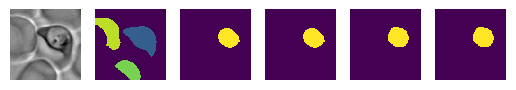

In [41]:
img_id = 1
z = 15
dataset = "mask-ts"

fix, ax = plt.subplots(1, 6)
ax[0].imshow(data_dict[dataset]["imgs"][img_id][z], interpolation="none", cmap="gray")
ax[1].imshow(data_dict[dataset]["rbc_pp"][img_id][z], interpolation="none")
ax[2].imshow(data_dict[dataset]["para_pred"][img_id][z], interpolation="none")
ax[3].imshow(data_dict[dataset]["para_merge"][img_id][z], interpolation="none")
ax[4].imshow(data_dict[dataset]["para_gt"][img_id][z], interpolation="none")
ax[5].imshow(data_dict[dataset]["para_gt_merge"][img_id][z], interpolation="none")

for axes in ax:
    axes.axis("off")

In [42]:
# mask -r and mask-ts
print(compute_auc(data_dict, stage='para_pred', gt_stage='para_gt' ))
print(compute_auc(data_dict, stage='para_merge', gt_stage='para_gt' ))
print(compute_auc(data_dict, stage='para_merge', gt_stage='para_gt_merge' ))
# these are not the original numbers anymore

0.6916995915499601
0.6916995915499601
0.6956521814519708


In [268]:
# only mask-r
print(compute_auc(data_dict, datasets=["mask-r"], stage='para_pred', gt_stage='para_gt' ))
print(compute_auc(data_dict, datasets=["mask-r"], stage='para_merge', gt_stage='para_gt' ))
print(compute_auc(data_dict, datasets=["mask-r"], stage='para_merge', gt_stage='para_gt_merge' ))


0.4236110773953525
0.45833336223255505
0.5075757720253684


In [38]:
# only mask-ts
print(compute_auc(data_dict, datasets=["mask-ts"], stage='para_pred', gt_stage='para_gt' ))
print(compute_auc(data_dict, datasets=["mask-ts"], stage='para_merge', gt_stage='para_gt' ))
print(compute_auc(data_dict, datasets=["mask-ts"], stage='para_merge', gt_stage='para_gt_merge'))

0.6916995915499601
0.6916995915499601
0.6956521814519708


In [273]:
radii = [0, 1, 2, 3]
do_3D_vals = [False, True]

metrics = np.zeros((len(radii), len(do_3D_vals), 3, 2))

for i, radius in enumerate(radii):
    for j, do_3D in enumerate(do_3D_vals):
        for dataset in data_dict:
            new_segs = []
            for seg in data_dict[dataset]["para_merge"]:
                new_seg = smooth_segments(seg, radius, do_3D)
                new_segs.append(new_seg)
            data_dict[dataset]["para_smooth"] = np.stack(new_segs)
        metrics[i, j, 0, 0] = compute_auc(data_dict, datasets=["mask-r"], stage="para_smooth", gt_stage="para_gt")
        metrics[i, j, 0, 1] = compute_auc(data_dict, datasets=["mask-r"], stage="para_smooth", gt_stage="para_gt_merge")
        metrics[i, j, 1, 0] = compute_auc(data_dict, datasets=["mask-ts"], stage="para_smooth", gt_stage="para_gt")
        metrics[i, j, 1, 1] = compute_auc(data_dict, datasets=["mask-ts"], stage="para_smooth", gt_stage="para_gt_merge")
        metrics[i, j, 2, 0] = compute_auc(data_dict, stage="para_smooth", gt_stage="para_gt")
        metrics[i, j, 2, 1] = compute_auc(data_dict, stage="para_smooth", gt_stage="para_gt_merge")


0.4917929389260032


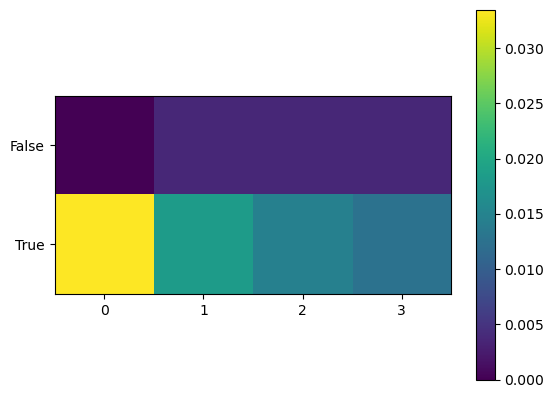

In [293]:
# mask-r
plt.imshow(metrics[:, :, 0, 0].T - compute_auc(data_dict, datasets=["mask-r"], stage='para_merge', gt_stage='para_gt' ))
plt.yticks(do_3D_vals, do_3D_vals)
plt.xticks(radii)
plt.colorbar()

print(metrics[:, :, 0, 0].max())

0.5151515007019043


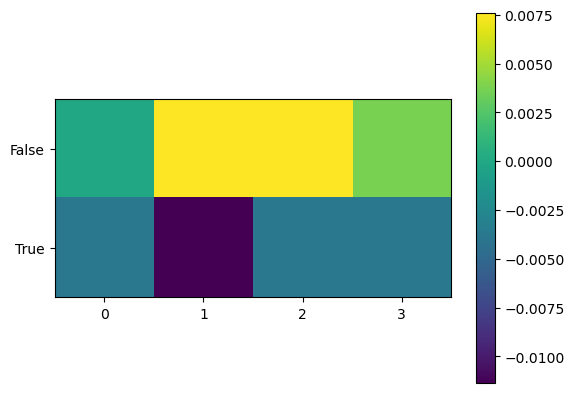

In [294]:
plt.imshow(metrics[:, :, 0, 1].T- compute_auc(data_dict, datasets=["mask-r"], stage='para_merge', gt_stage='para_gt_merge' ))
plt.yticks(do_3D_vals, do_3D_vals)
plt.xticks(radii)
plt.colorbar()

print(metrics[:, :, 0, 1].max())


 --> different optimal settings depending whether the GT is clipped to the RBC segment. Since these might be faulty, better stick to the values for the orignal GT.

In [ ]:
# mask-ts

0.6561264991760254


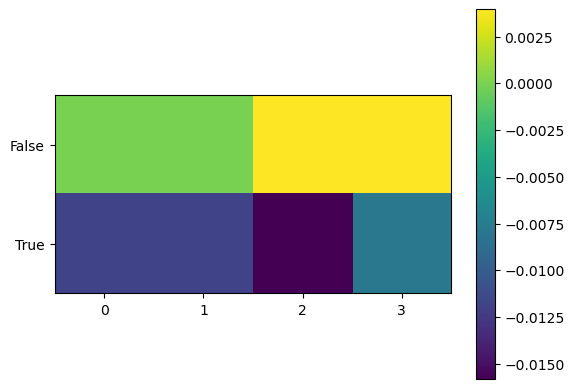

In [296]:
plt.imshow(metrics[:, :, 1, 0].T- compute_auc(data_dict, datasets=["mask-ts"], stage='para_merge', gt_stage='para_gt' ))
plt.yticks(do_3D_vals, do_3D_vals)
plt.xticks(radii)
plt.colorbar()

print(metrics[:, :, 1, 0].max())

0.6859504092823375


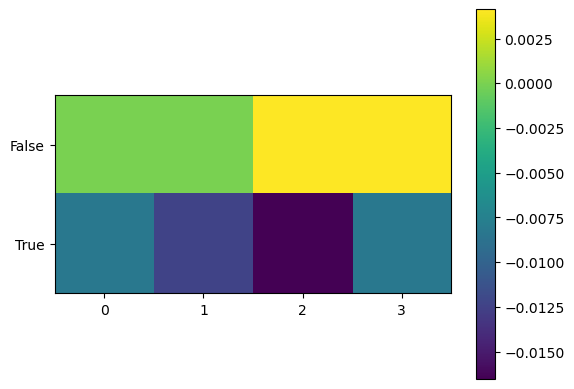

In [298]:
plt.imshow(metrics[:, :, 1, 1].T - compute_auc(data_dict, datasets=["mask-ts"], stage='para_merge', gt_stage='para_gt_merge'))
plt.yticks(do_3D_vals, do_3D_vals)
plt.xticks(radii)
plt.colorbar()

print(metrics[:, :, 1, 1].max())

--> only small improvement, always best without 3D and with aggressive smoothing

0.5644745826721191


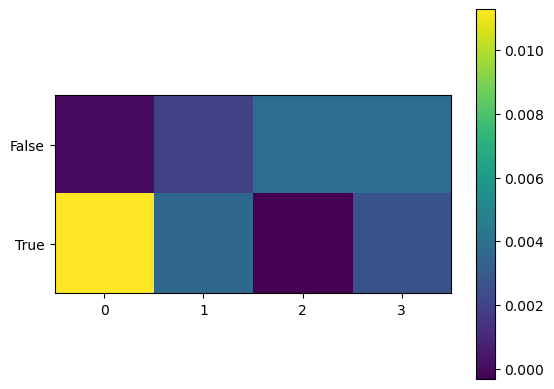

In [299]:
# mask-r and mask-ts
plt.imshow(metrics[:, :, 2, 0].T- compute_auc(data_dict, stage='para_merge', gt_stage='para_gt' ))
plt.yticks(do_3D_vals, do_3D_vals)
plt.xticks(radii)
plt.colorbar()

print(metrics[:, :, 2, 0].max())

0.5968379540876909


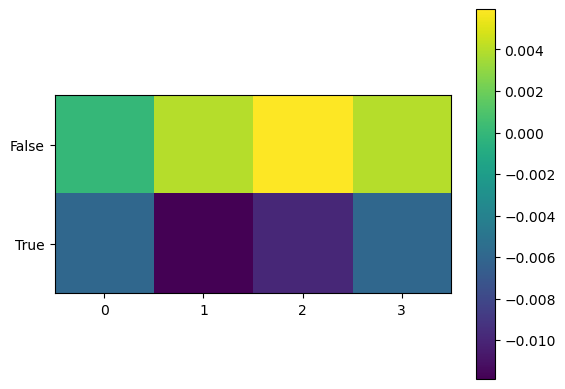

In [300]:
plt.imshow(metrics[:, :, 2, 1].T -compute_auc(data_dict, stage='para_merge', gt_stage='para_gt_merge' ))
plt.yticks(do_3D_vals, do_3D_vals)
plt.xticks(radii)
plt.colorbar()
print(metrics[:, :, 2, 1].max())

# on relevant data (only qualitatively)

In [2]:
data_dir = "/export/home/sdamrich/data_ial/sfb1129/protein_kinetics/data_20221025"
dataset = "wholelife"
exp_str_rbc = "data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_fold_0_of_1_epoch_499_aniso_3.2"

In [3]:
imgs, _, file_names = load_data(data_dir, dataset)
pred_rbc = load_predictions(data_dir, dataset, file_names, exp_str_rbc)



In [85]:
file_names

array(['C2-FCR3_KM_B4_15_03processed_1-1',
       'C2-FCR3_KM_B4_15_03processed_1-2',
       'C2-FCR3_KM_B4_15_03processed_1-3',
       'C2-FCR3_KM_B4_15_03processed_11-1',
       'C2-FCR3_KM_B4_15_03processed_12-1',
       'C2-FCR3_KM_B4_15_03processed_13-2',
       'C2-FCR3_KM_B4_15_03processed_13-3',
       'C2-FCR3_KM_B4_15_03processed_14-1',
       'C2-FCR3_KM_B4_15_03processed_15-3',
       'C2-FCR3_KM_B4_15_03processed_15-4',
       'C2-FCR3_KM_B4_15_03processed_15-5',
       'C2-FCR3_KM_B4_15_03processed_16-1',
       'C2-FCR3_KM_B4_15_03processed_17-1',
       'C2-FCR3_KM_B4_15_03processed_17-2',
       'C2-FCR3_KM_B4_15_03processed_2-1',
       'C2-FCR3_KM_B4_15_03processed_5-1',
       'C2-FCR3_KM_B4_15_03processed_6-1',
       'C2-FCR3_KM_B4_18_processed-1-1',
       'C2-FCR3_KM_B4_18_processed-10-1',
       'C2-FCR3_KM_B4_18_processed-10-2',
       'C2-FCR3_KM_B4_18_processed-11-1',
       'C2-FCR3_KM_B4_18_processed-16-2',
       'C2-FCR3_KM_B4_18_processed-18-1',
       

In [136]:
np.where(file_names == "C2-FCR3_KM_B4_21_-01processed-21-1")

(array([37]),)

In [138]:
img_id = 37
file_names[img_id]

'C2-FCR3_KM_B4_21_-01processed-21-1'

In [139]:
seg = pred_rbc[img_id]

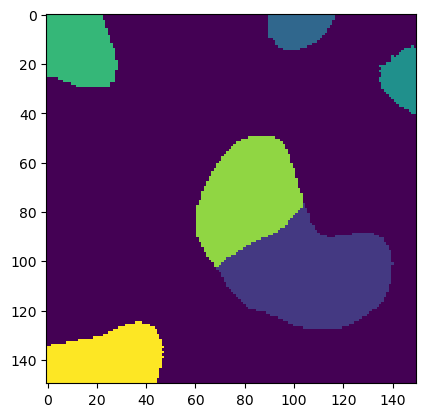

In [140]:
t = 20
z = 12

plt.imshow(seg[t][z], interpolation="none")

In [141]:
id_main = find_central_id(seg[t], 30)
print(id_main)

5


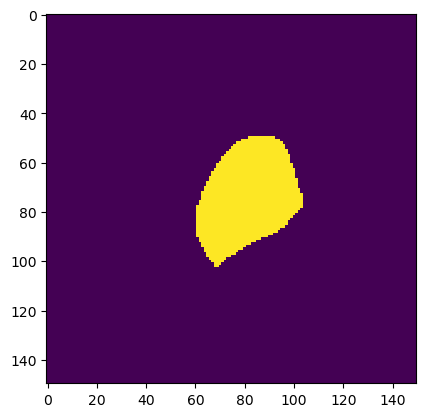

In [142]:
plt.imshow(seg[t][z] == id_main, interpolation="none")

In [143]:
merged = handle_small_segments_simple(seg[t], nbhd_size=1)

{'nb_ids': array([1], dtype=uint16), 'contact': array([789])}
Ratio: 0.8436272878535773
Merged ratio: 0.8007643756146751
Relative change: -0.05080787790536914



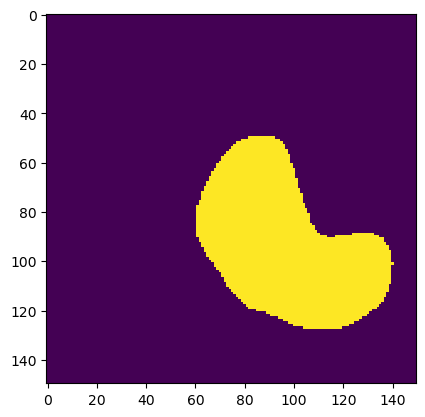

In [144]:

plt.imshow(merged[z], interpolation="none")